In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# .values ile from dataframe to numpy array dönüşümü yapılması gerekli. yoksa hata verir.
x, y = mnist["data"].values, mnist["target"].values

print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images and each image has 784 features. This is because each image is 28x28 pixels. And each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). 

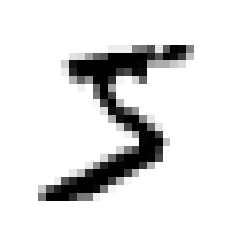

'5'

In [3]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = x[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mlp.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

y[0]

In [4]:
import numpy as np 

# the labels are strings. But we prefer numbers
y = y.astype(np.uint8)

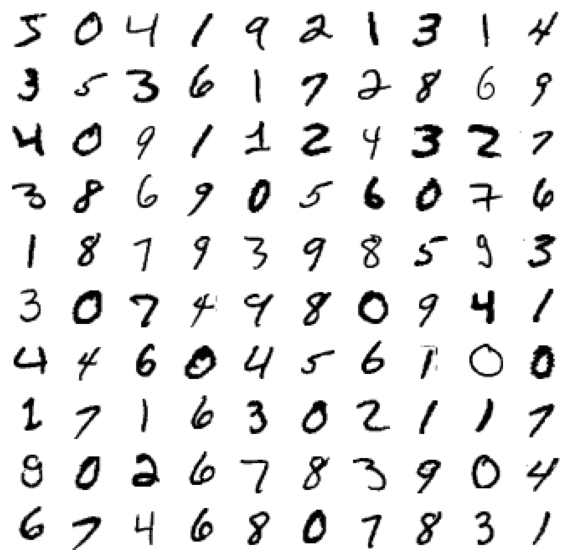

In [5]:
# Some more handwritten numbers showed
plt.figure(figsize = (10, 10))
for i in range(100):
    plt.subplot(10, 10, (i + 1))
    plt.imshow(x[(i)].reshape(28, 28), cmap = mlp.cm.binary)
    plt.axis('off')

In [6]:
# The MNIST dataset is actually already split into a training set 
# (the first 60,000 images) and a test set (the last 10,000 images)

x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, so all cross-validation folds will be similar

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit (for example 5, this is 5 detector.)
Will be an exampe of a binary classifier, capable of distinguishing between just two classes 5 or not 5

In [7]:
y_train_5 = (y_train == 5)    # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

#Stochastic Gradient Descent (SGD Classifier)
# This classifier has an advantage of being capable of handling very large datasets efficiently
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
# some_digit = 5 from above
sgd_clf.predict([some_digit])

array([ True])

## Measuring Accuracy Using Cross-Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(sgd_clf, x_train, y_train_5, cv = 3, scoring = 'accuracy')
cvs

array([0.95035, 0.96035, 0.9604 ])

Don't let these accuracy ratios surprise you. These accuracies simply because only about 10% of the images are 5s, so if you always predict an image is not a 5, you will get about 90% of accuracy.

## Confusion Matrix

In [11]:
# Just like cross_val_score() function, cross_val_predict() performs K-fold cross-validation,
# but instead of returning the evaluation scores, it returns the predicions made on each test fold.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

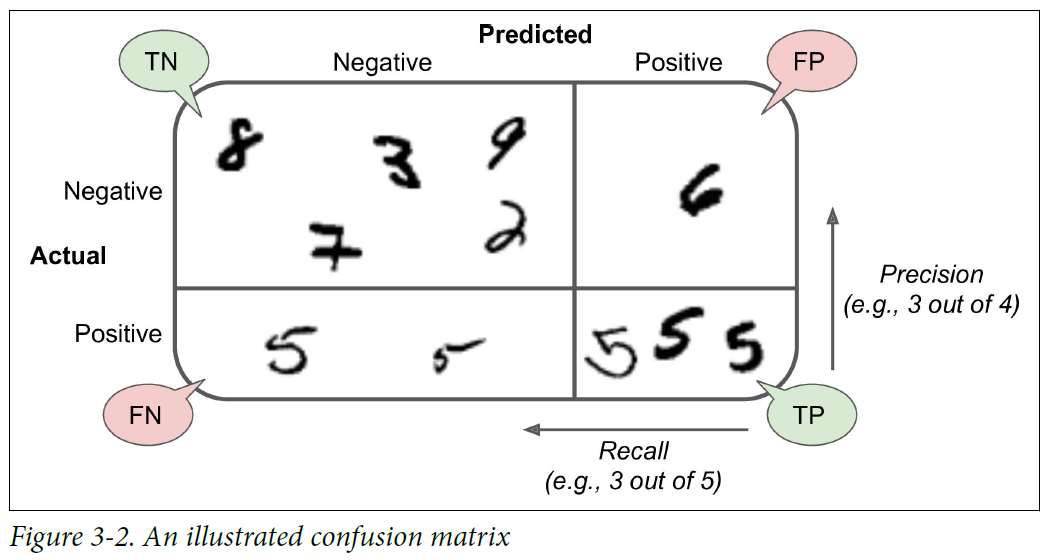
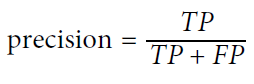
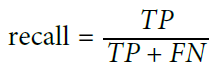
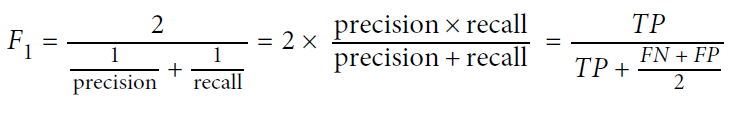

## Precision and Recall

In [13]:
from sklearn.metrics import precision_score, recall_score

print('Precision: ', precision_score(y_train_5, y_train_pred))    # The model correct only precision score

print('Recall: ', recall_score(y_train_5, y_train_pred))          # The model only detects the 5 in recall score

Precision:  0.8370879772350012
Recall:  0.6511713705958311


Increasing **precision** reduces **recall**, and vice versa. This is called the precision/recall tradeoff

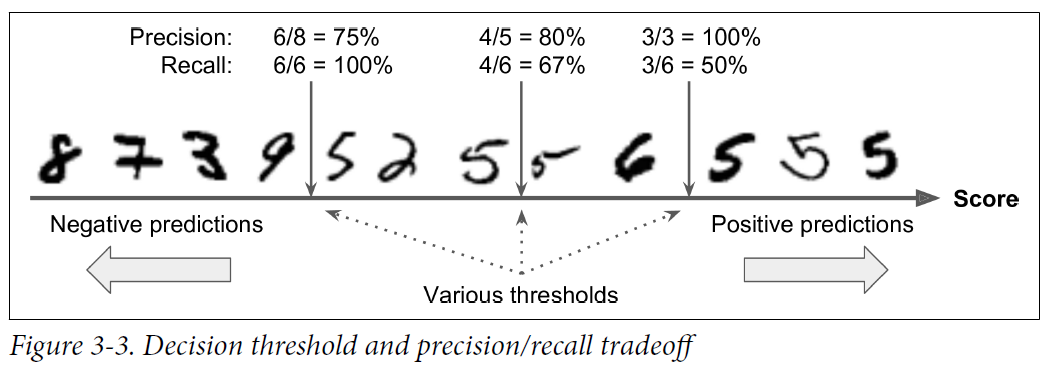

## f1 Score

In [14]:
from sklearn.metrics import f1_score

print('f1 score: ', f1_score(y_train_5, y_train_pred))

f1 score:  0.7325171197343846


## Precision and Recall Tradeoff

In [15]:
from sklearn.linear_model import SGDClassifier

# .decision_function() method, which returns a score for each instance, 
# and then make predictions based on those scores using any threshold you want
y_scores = sgd_clf.decision_function([some_digit])   # some_digit = 5
y_scores

array([2164.22030239])

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do we decide which threshold to use? 
- For this we will first need to get the all scores of all instances in the training set using the cross_val_predict() method. But this time specifying that we want return decision scores instead predictions

In [23]:
from sklearn.model_selection import cross_val_predict

# with these scores we can compute precision and recall for all possible thresholds using the precision_recall_curve() method
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3, method = 'decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

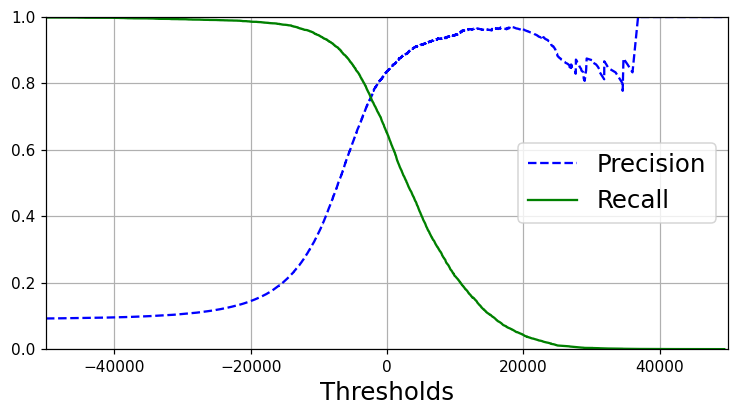

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[: -1], 'g-', label = 'Recall')
    plt.legend(loc = 'center right', fontsize = 16)
    plt.xlabel('Thresholds', fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plt.figure(figsize=(8, 4), dpi = 110)   
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.savefig("precision_recall_vs_threshold_plot")

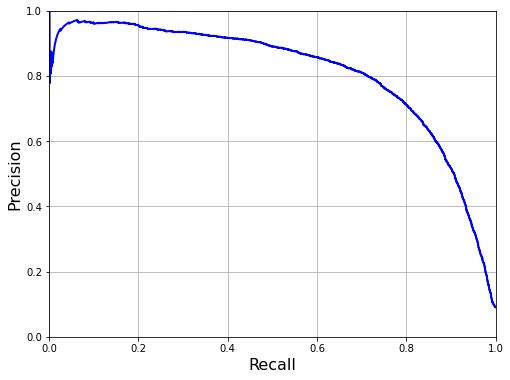

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth = 2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

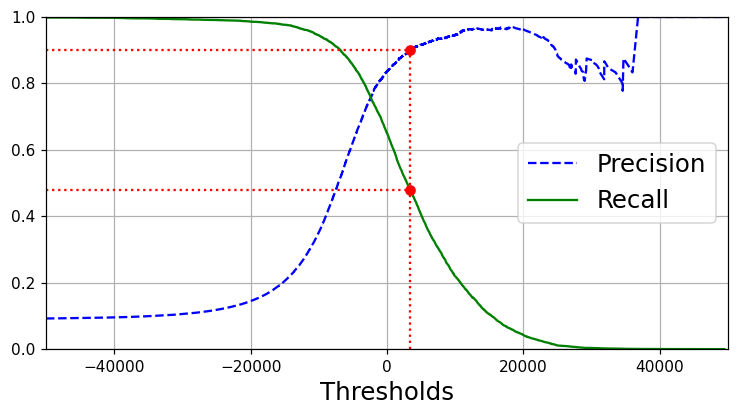

In [44]:
'''
let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value)
'''
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4), dpi = 110)  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  

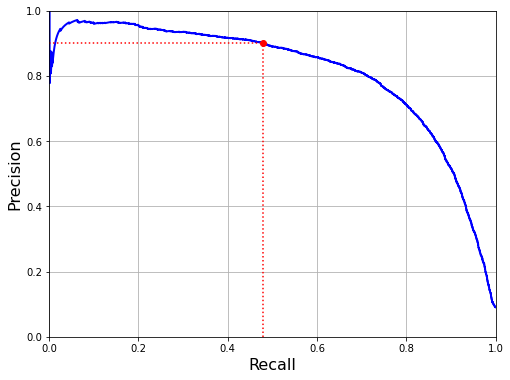

In [46]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.savefig("precision_vs_recall_plot")

In [47]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print('Precision Score: ', precision_score(y_train_5, y_train_pred_90))
print('Recall Score: ', recall_score(y_train_5, y_train_pred_90))

Precision Score:  0.9000345901072293
Recall Score:  0.4799852425751706


**A high-precision classifier is not very useful if its recall is too low!**

## The ROC Curve

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

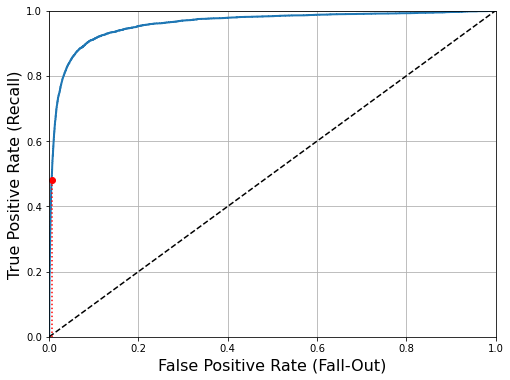

In [52]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = None, linewidth = 2)
    plt.plot([0, 1], [0, 1], 'k--')   # dashed diagonal
    
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.savefig("roc_curve_plot")

In [53]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC curve is similar to precision/recall curve. Which one to choose?

* If positive class is rare or when you care more about the false positives than the false negatives, must be choosen the PR curve
* Otherwive ROC curve

*In this example, it would be more accurate to chose the PR curve*